In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [2]:
data = pd.read_csv('retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

# Оценивание
За выполнени каждого задания 1 балл

4 балла -> отл

3 балла -> хор

И тд

### Задание 0. Товар 999999
На вебинаре мы использовали товар 999999 - это товар, который купили пользователи, если они купиши товар из top5000. Используя этот товар мы смещяем качество рекомендаций. В какую сторону? Уберите этот товар и сравните с качеством на семинаре.

Качество снижается при добавлении 999999. Модель не учитывала этот товар при обучении, поэтому появление его в ответе штрафует модель за неверный ответ. 

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [4]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(10)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."
5,9,"[864335, 990865, 1029743, 9297474, 10457112, 8..."
6,13,"[6534178, 1104146, 829197, 840361, 862070, 884..."
7,14,"[840601, 867293, 933067, 951590, 952408, 96569..."
8,15,"[910439, 1082185, 959076, 1023958, 1082310, 13..."
9,16,"[1062973, 1082185, 13007710]"


In [5]:
item_logs = np.log(data_train['item_id'].value_counts())
items_weights = item_logs / item_logs.sum()
items_weights = items_weights.reset_index()
items_weights.columns = ['item_id', 'weights']
items_weights

,item_id,weights
0,1082185,0.000078
1,6534178,0.000075
2,1029743,0.000073
3,995242,0.000072
4,1106523,0.000070
...,...,...
86860,728420,0.000000
86861,15863990,0.000000
86862,13774936,0.000000
86863,1185885,0.000000


In [6]:
items_weights['weights'].sum()

1.0

In [7]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    weights = np.array(items_weights['weights'])
    items = np.array(items_weights['item_id'])
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

Сделайте предсказания

In [8]:
%%time

result['weighted_random_recommendation'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights))
result.head(5)

Wall time: 3.57 s


,user_id,actual,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[440156, 1117707, 1130507, 888577, 857939]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[15452576, 10120170, 892767, 13132044, 1020308]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1026931, 1134669, 10311727, 1355598, 1000630]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[835787, 88163, 5979414, 12605136, 924446]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[13947683, 6534002, 15679390, 867874, 824475]"


### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [9]:
result = pd.read_csv('predictions_basic.csv')
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,[ 821867 834484 856942 865456 889248 ...,"[9487983, 1076744, 887219, 13842075, 12526891]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,[ 835476 851057 872021 878302 879948 ...,"[1679875, 10149658, 6391089, 888997, 1008799]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[999999, 1082185, 1098066, 6534178, 1127831]"


In [10]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    
    recommended_list = np.array(recommended_list)
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    return precision

In [23]:
def evaluation(data):
    for column in data.columns[2:]:
        result = data.apply(lambda row: precision_at_k(row[column], row['actual'], k=5), axis=1).mean()
        print(f'{column} : {result}')

In [24]:
evaluation(result)

IndexError: too many indices for array

долго ковырялся, но так и не понял, почему не работает. функция такая же, как на уроке. При этом, не работает и функция с урока, хотя в ноутбуке с лекцией код заработал....
см скрин


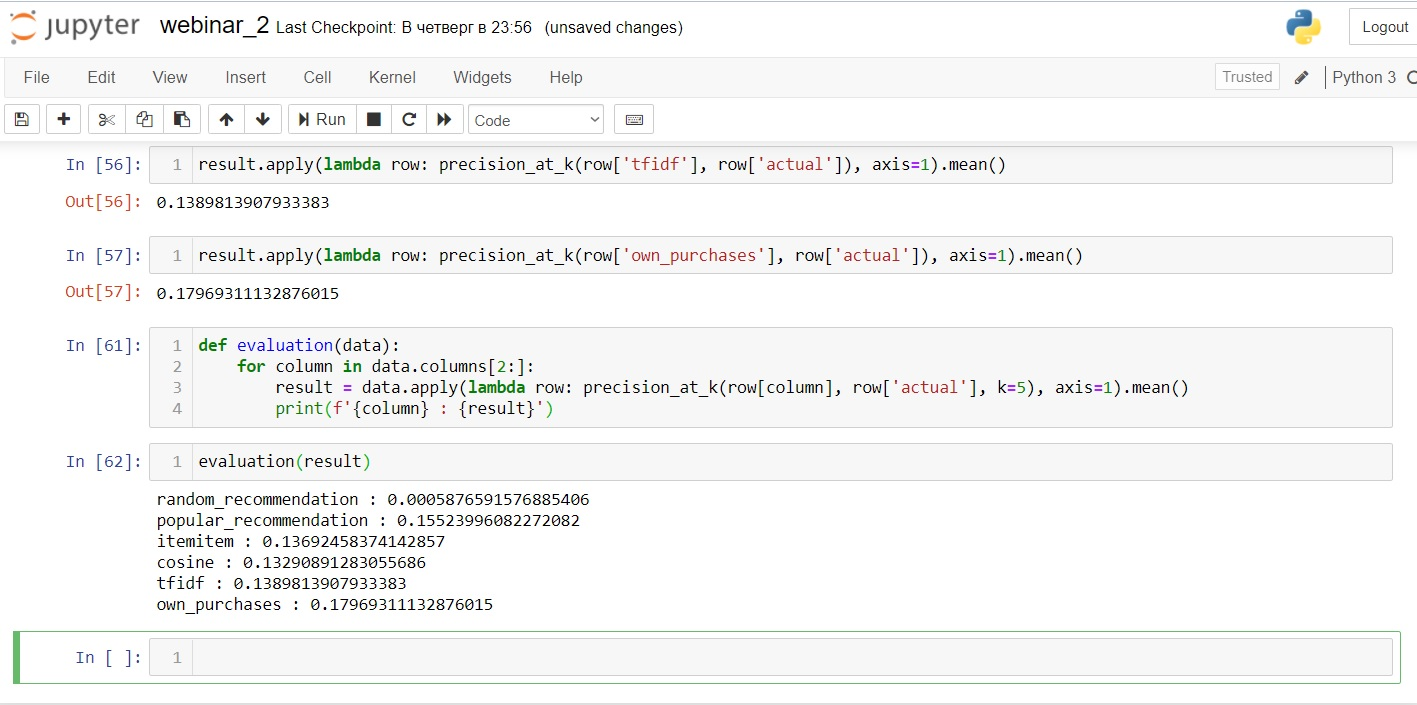

In [13]:
from IPython.display import Image
Image("eval.jpg")

In [ ]:
Лучшее качество показало own_purchases

### Задание 3. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров

In [14]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [15]:
def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [16]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()
top_5000[:5]

[6534178, 6533889, 6534166, 6544236, 1404121]

In [17]:
data_test_top_5k = data_test[data_test['item_id'].isin(top_5000)]
result1 = data_test_top_5k.groupby('user_id')['item_id'].unique().reset_index()
result1.columns=['user_id', 'actual']
result1.head()

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 914190, 95804..."
1,3,"[851057, 872021, 878302, 879948, 909638, 91320..."
2,6,"[920308, 926804, 1017061, 1078346, 1120741, 82..."
3,7,"[840386, 889774, 898068, 909714, 953476, 97699..."
4,8,"[835098, 872137, 910439, 924610, 1041259, 5569..."


In [18]:
%%time

items = data_train.item_id.unique()

result1['random_recommendation'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))
result1.head()

Wall time: 3.34 s


,user_id,actual,random_recommendation
0,1,"[821867, 834484, 856942, 865456, 914190, 95804...","[10356401, 2484265, 9837210, 10121942, 2522053]"
1,3,"[851057, 872021, 878302, 879948, 909638, 91320...","[1100375, 9553101, 1124122, 1004119, 13008151]"
2,6,"[920308, 926804, 1017061, 1078346, 1120741, 82...","[5780767, 1076460, 1111763, 13115813, 9297211]"
3,7,"[840386, 889774, 898068, 909714, 953476, 97699...","[15452360, 10457194, 2048371, 849756, 875034]"
4,8,"[835098, 872137, 910439, 924610, 1041259, 5569...","[966864, 1076418, 7028284, 9677791, 1085138]"


In [19]:
%%time

# Можно так делать, так как рекомендация не зависит от юзера
popular_recs = popularity_recommendation(data_train, n=5)

result1['popular_recommendation'] = result['user_id'].apply(lambda x: popular_recs)
result1.head()

Wall time: 120 ms


,user_id,actual,random_recommendation,popular_recommendation
0,1,"[821867, 834484, 856942, 865456, 914190, 95804...","[10356401, 2484265, 9837210, 10121942, 2522053]","[6534178, 6533889, 1029743, 6534166, 1082185]"
1,3,"[851057, 872021, 878302, 879948, 909638, 91320...","[1100375, 9553101, 1124122, 1004119, 13008151]","[6534178, 6533889, 1029743, 6534166, 1082185]"
2,6,"[920308, 926804, 1017061, 1078346, 1120741, 82...","[5780767, 1076460, 1111763, 13115813, 9297211]","[6534178, 6533889, 1029743, 6534166, 1082185]"
3,7,"[840386, 889774, 898068, 909714, 953476, 97699...","[15452360, 10457194, 2048371, 849756, 875034]","[6534178, 6533889, 1029743, 6534166, 1082185]"
4,8,"[835098, 872137, 910439, 924610, 1041259, 5569...","[966864, 1076418, 7028284, 9677791, 1085138]","[6534178, 6533889, 1029743, 6534166, 1082185]"


In [20]:
%%time

result1['weighted_random_recommendation'] = result1['user_id'].apply(lambda x: weighted_random_recommendation(items_weights))
result1.head()

Wall time: 3.27 s


,user_id,actual,random_recommendation,popular_recommendation,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 914190, 95804...","[10356401, 2484265, 9837210, 10121942, 2522053]","[6534178, 6533889, 1029743, 6534166, 1082185]","[8068722, 9487466, 12263963, 2015837, 6442459]"
1,3,"[851057, 872021, 878302, 879948, 909638, 91320...","[1100375, 9553101, 1124122, 1004119, 13008151]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1037092, 991900, 38112, 871812, 1174463]"
2,6,"[920308, 926804, 1017061, 1078346, 1120741, 82...","[5780767, 1076460, 1111763, 13115813, 9297211]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1000350, 1112205, 15629930, 1867210, 12812554]"
3,7,"[840386, 889774, 898068, 909714, 953476, 97699...","[15452360, 10457194, 2048371, 849756, 875034]","[6534178, 6533889, 1029743, 6534166, 1082185]","[15596013, 234975, 7443447, 93003, 10141780]"
4,8,"[835098, 872137, 910439, 924610, 1041259, 5569...","[966864, 1076418, 7028284, 9677791, 1085138]","[6534178, 6533889, 1029743, 6534166, 1082185]","[317231, 13512521, 15863593, 943669, 6442668]"


In [22]:
evaluation(result1)


random_recommendation : 0.0007092198581560283
popular_recommendation : 0.1605876393110415
weighted_random_recommendation : 0.0


- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.


In [25]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

C:\Users\vladi\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
user_item_matrix.sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100

5.33770796861036

In [26]:

userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [92]:
%%time

model = ItemItemRecommender(K=2, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


Wall time: 695 ms


In [93]:
%%time

result1['itemitem'] = result1['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

Wall time: 40.9 ms


In [94]:
result1.apply(lambda row: precision_at_k(row['itemitem'], row['actual']), axis=1).mean()


0.19862377575143236

* k=1: 0.1861870989530538
* k=2: 0.19862377575143236
* k=3: 0.19250253292806194
* k=4: 0.1499493414387013
* k=5: 0.14164133738601678
* k=6: 0.14690982776088995
* k=7: 0.1498480243161077
* k=8: 0.1522796352583569
* k=9: 0.15359675785207527
* k=10: 0.15612968591691803

-  *Попробуйте стратегии ансамблирования изученных алгоритмов

NaN

### Задание 4. Улучшение детерминированных алгоритмов
На семинаре мы рассматривали 



Далее $U \equiv N_i(u) $

$$r_{u,i} =  \frac{1}{S}\sum\limits_{v \in U}\operatorname{sim}(u,v)r_{v, i}$$
$$ S = \sum\limits_{v \in U} \operatorname{sim}(u,v)$$

Предлагается улучшить эту формулу и учесть средние предпочтения всех пользователей

$$r_{u,i} = \mu + \bar{r_u} + \frac{1}{S}\sum\limits_{v \in U}\operatorname{sim}(u,v)(r_{v, i}-\bar{r_{v}} - \mu)$$

Какие смысл имееют $ \mu $ и $ \bar{r_u}$ ?

Реализуйте алгоритм, прогнозирующий рейтинги на основе данной формулы, на numpy (векторизованно!)

В качестве схожести возьмите CosineSimilarity.

Примените к user_item_matrix. В качестве рейтингов возьмите количество или стоимость купленного товара. 
Данный алгоритм предсказывает рейтинги. Как на основании предсказанных рейтингов предсказать факт покупки?

Предложите вариант.
Посчитайте accuracy@5 и сравните с алгоритмами, разобранными на вебинаре.